In [1]:
import datetime as dt
import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt
import torch, pyro, math
import pyro.distributions as dist
from pathlib import Path
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO, Predictive
from pyro.infer.autoguide import AutoNormal
from pyro.nn import pyro_method
from scipy.interpolate import PchipInterpolator
from tqdm.auto import trange
from epiweeks import Week, Year

# Function definitions

## Incidence

In [2]:
def get_df(csv_path):
    df_raw = pd.read_csv(csv_path, compression='gzip')
    df_raw = df_raw.rename(columns={'geocode':"city_idx", 'casos':"Y_obs"})
    return df_raw

In [3]:
def set_week_idx(df):
    df['date'] = pd.to_datetime(df['date'])
    df['calendar_year'] = df['date'].dt.year
    year_id_map = {y: i for i, y in enumerate(sorted(df['calendar_year'].unique()))}
    df['year_idx'] = df['calendar_year'].map(year_id_map)
    week_table = (df[['date']]
                  .drop_duplicates()
                  .sort_values('date')
                  .reset_index(drop=True)
                  .assign(week_idx=lambda t: t.index))
    return df.merge(week_table, on='date', how='left')

In [4]:
def reindex_city_and_date(df_orig):
    df = df_orig.copy()
    df = df.sort_values(['date', 'uf'])
    df['date'] = pd.to_datetime(df['date'])
    df['calendar_year'] = df['date'].dt.year

    year_id_map = {y: i for i, y in enumerate(sorted(df['calendar_year'].unique()))}
    df['year_idx'] = df['calendar_year'].map(year_id_map)
    week_table = (df[['date']]
                  .drop_duplicates()      # many cities, one week‑row left
                  .sort_values('date')
                  .reset_index(drop=True)
                  .assign(week_idx=lambda t: t.index))

    df = df.merge(week_table, on='date', how='left')

    return df


## Population

In [5]:
def iso_weeks_in_year(year):
    return dt.date(year, 12, 28).isocalendar().week

In [6]:
def make_week_axis(epi_df, first_year, last_year):
    weeks_obs = epi_df.drop_duplicates(['calendar_year', 'epiweek']).groupby('calendar_year')['epiweek'].nunique()
    years = np.arange(first_year, last_year + 1)
    weeks_full = pd.Series({y: iso_weeks_in_year(y) for y in years}, dtype=int)
    weeks_full.update(weeks_obs)
    week_start = weeks_full.cumsum().shift(fill_value=0)
    weeks = np.arange(0, int(week_start.loc[last_year]) + 1)
    return week_start, weeks

In [7]:
def weekly_interpolated(pop_df, epi_df, end_year=2026):
    pop_df = pop_df.copy()
    first_year = pop_df['year'].min()
    week_start, weeks = make_week_axis(epi_df, first_year, end_year)
    
    def interpolate_one(city_df):
        city_df = city_df.drop_duplicates('year', keep='last').sort_values('year')
        t_knots = city_df['year'].map(week_start).to_numpy()
        y_knots = city_df['population'].to_numpy()
        uniq = np.r_[True, np.diff(t_knots) > 0]
        t_knots, y_knots = t_knots[uniq], y_knots[uniq]
        spline = PchipInterpolator(t_knots, y_knots, extrapolate=True)
        out = pd.DataFrame({
            'geocode': city_df['geocode'].iloc[0],
            'UF': city_df['UF'].iloc[0],
            'week_idx': weeks,
            'population': spline(weeks)
        })
        return out
        
    return pop_df.groupby('geocode', group_keys=False).apply(interpolate_one).reset_index(drop=True)

In [8]:
def read_population(file_path, uf_map):
    population = pd.read_csv(file_path)
    target_geocode = list(uf_map.keys())
    population = population[population["geocode"].isin(target_geocode)]
    population["UF"] = population["geocode"].map(uf_map)
    return population

## Geographic distances

In [9]:
def read_regic(file_path):
    regic = pd.read_excel(file_path)
    regic['NOME_CIDADE'] = regic['NOME_CIDADE'].str.replace(r'^Arranjo Populacional( Internacional)? (da|de|do) ', '', regex=True).replace(r'/([A-Z]{2}|[A-Z][a-z]+)', '', regex=True).values
    return regic.rename(columns={"COD_CIDADE":"geocode", "NOME_CIDADE":"name_muni"})

In [10]:
def get_geodataframe(target_geocode, target_crs):
    gdf_ibge = gpd.read_file(f"zip://{zip_file_path}").to_crs(target_crs)
    gdf_ibge.rename(columns={"NM_MUN": "name_muni", "CD_MUN": "geocode"}, inplace=True)
    gdf_ibge["geocode"] = gdf_ibge["geocode"].astype(int)
    gdf_ibge = gdf_ibge.sort_values(by=["geocode"]).reset_index(drop=True)
    gdf_ibge = gdf_ibge[gdf_ibge["geocode"].isin(target_geocode)]
    return gdf_ibge

## Model

In [11]:
def fourier_wrapped_gaussian(t, mu, sigma, T=52.1772, N=20):
    device, dtype = t.device, t.dtype
    n = torch.arange(0, N + 1, device=device, dtype=dtype)          
    coef = torch.exp(-2.0 * math.pi**2 * sigma[:, None]**2 * n**2 / T**2)  
    phase = 2.0 * math.pi * (t[None, :] - mu[:, None])[:, :, None] * n / T  
    series = (coef[:, None, :] * torch.cos(phase)).sum(-1)              
    return series / series.max(dim=1, keepdim=True).values

# Data pre-processing

## Incidence

In [12]:
csv_path = "./Data/data_sprint_2025/dengue.csv.gz"
epi_df = get_df(csv_path)
epi_df = reindex_city_and_date(epi_df)

In [13]:
uf_map = epi_df[["city_idx", "uf"]].drop_duplicates().pivot_table(columns="city_idx", values="uf", aggfunc="first").to_dict()
uf_map = {k:v['uf'] for k,v in uf_map.items()}

In [14]:
states = epi_df[["uf", "Y_obs"]].groupby(["uf"]).sum().reset_index().sort_values(by=["Y_obs"], ascending=False).reset_index(drop=True)

In [15]:
state_id_map = {old: new for new, old in enumerate(states['uf'])}
epi_df['state_idx'] = epi_df['uf'].map(state_id_map)
epi_df = epi_df.sort_values(["date", "state_idx"]).reset_index(drop=True)
epi_df

,date,epiweek,city_idx,Y_obs,uf,macroregional_geocode,regional_geocode,train_1,target_1,train_2,target_2,train_3,target_3,calendar_year,year_idx,week_idx,state_idx
0,2010-01-03,201001,3500105,2,SP,3533,35091,True,False,True,False,True,False,2010,0,0,0
1,2010-01-03,201001,3500204,0,SP,3531,35156,True,False,True,False,True,False,2010,0,0,0
2,2010-01-03,201001,3500303,0,SP,3528,35142,True,False,True,False,True,False,2010,0,0,0
3,2010-01-03,201001,3500402,0,SP,3528,35142,True,False,True,False,True,False,2010,0,0,0
4,2010-01-03,201001,3500501,0,SP,3528,35074,True,False,True,False,True,False,2010,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4471804,2025-05-25,202522,1400050,0,RR,1401,14001,False,False,False,False,False,True,2025,15,803,26
4471805,2025-05-25,202522,1400027,0,RR,1401,14001,False,False,False,False,False,True,2025,15,803,26
4471806,2025-05-25,202522,1400407,1,RR,1401,14001,False,False,False,False,False,True,2025,15,803,26
4471807,2025-05-25,202522,1400506,0,RR,1401,14002,False,False,False,False,False,True,2025,15,803,26


In [16]:
inverse_state_id_map = {v:k for k, v in state_id_map.items()}

## Population

In [17]:
file_path = "Data/data_sprint_2025/datasus_population_2001_2024.csv.gz"
population = read_population(file_path, uf_map)
population = population[population["year"] > 2007]
population = population.sort_values(by=["year", "geocode"]).reset_index(drop=True)
population['year'] = population['year'] + 2
population

,geocode,year,population,UF
0,1100015,2010,25440,RO
1,1100023,2010,88293,RO
2,1100031,2010,6687,RO
3,1100049,2010,78105,RO
4,1100056,2010,17598,RO
...,...,...,...,...
94685,5222005,2026,15476,GO
94686,5222054,2026,9077,GO
94687,5222203,2026,4185,GO
94688,5222302,2026,5982,GO


In [18]:
weekly_pop = weekly_interpolated(population, epi_df)
weekly_pop["population"] += 200
weekly_pop = weekly_pop[weekly_pop["week_idx"] < 804]
weekly_pop = weekly_pop.groupby(["week_idx", "UF"]).sum().reset_index()[["week_idx", "UF", "population"]]
weekly_pop = weekly_pop.sort_values(by=["week_idx", "population"], ascending=[True, False]).reset_index(drop=True)
weekly_pop

/tmp/ipykernel_1878/1972061969.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return pop_df.groupby('geocode', group_keys=False).apply(interpolate_one).reset_index(drop=True)


,week_idx,UF,population
0,0,SP,4.181165e+07
1,0,MG,1.980383e+07
2,0,RJ,1.641715e+07
3,0,BA,1.412061e+07
4,0,RS,1.089814e+07
...,...,...,...
21703,803,RO,1.756292e+06
21704,803,TO,1.604573e+06
21705,803,AC,8.848044e+05
21706,803,AP,8.058294e+05


## Geographic distances

In [19]:
pop = population[population["year"] == 2024]

In [20]:
file_path = 'Data/REGIC2018_Cidades_v2.xlsx'
regic = read_regic(file_path)

In [21]:
regic_p = regic.merge(pop[['geocode', 'population']], on=['geocode'], how='left')
regic_p = regic_p.loc[regic_p.groupby("UF")["population"].idxmax(), ["UF", "name_muni", "geocode", "population"]].sort_values(by="population", ascending=False).reset_index(drop=True)
regic_p = regic_p.groupby("UF").sum(["population"]).reset_index()

In [22]:
crs_metric = "EPSG:3857"
zip_file_path = "Data/BR_Municipios_2024.zip"
gdf = get_geodataframe(regic_p["geocode"], crs_metric)

In [23]:
gdf["SIGLA_UF"] = pd.Categorical(gdf["SIGLA_UF"], categories=states["uf"], ordered=True)
gdf_sorted = gdf.sort_values("SIGLA_UF")

In [24]:
gdf_sorted = gdf_sorted.geometry
D  = np.zeros((27, 27), dtype=float)
for i, gi in enumerate(gdf_sorted):
    dist_ = gdf_sorted.distance(gi)
    D[i, :] = dist_
D += np.eye(27) * 1e-9

# Traning

In [25]:
train_goal = "train_3"
target_goal = "target_3"

In [26]:
epi_df_tr = (epi_df[epi_df[train_goal]]
              .groupby(["date", "week_idx", "uf", "state_idx"])
              .sum("Y_obs")
              .reset_index()[["date", "week_idx", "state_idx", "uf", "Y_obs"]]
              .sort_values(["date", "state_idx"])
              .reset_index(drop=True)
              .rename(columns={"uf": "UF"}))
epi_df_tr

,date,week_idx,state_idx,UF,Y_obs
0,2010-01-03,0,0,SP,1628
1,2010-01-03,0,1,MG,2124
2,2010-01-03,0,2,GO,5163
3,2010-01-03,0,3,PR,110
4,2010-01-03,0,4,RJ,289
...,...,...,...,...,...
20380,2024-06-16,754,22,MA,92
20381,2024-06-16,754,23,RO,32
20382,2024-06-16,754,24,SE,51
20383,2024-06-16,754,25,AP,206


In [27]:
epi_df_tr = epi_df_tr.merge(weekly_pop[['UF', 'week_idx', 'population']], on=['UF', 'week_idx'], how='left', validate='many_to_one')

In [28]:
epi_df_tr['Y_per_pop'] = epi_df_tr['Y_obs'] / epi_df_tr['population']

In [29]:
epi_df_tr

,date,week_idx,state_idx,UF,Y_obs,population,Y_per_pop
0,2010-01-03,0,0,SP,1628,4.181165e+07,0.000039
1,2010-01-03,0,1,MG,2124,1.980383e+07,0.000107
2,2010-01-03,0,2,GO,5163,6.047818e+06,0.000854
3,2010-01-03,0,3,PR,110,1.057842e+07,0.000010
4,2010-01-03,0,4,RJ,289,1.641715e+07,0.000018
...,...,...,...,...,...,...,...
20380,2024-06-16,754,22,MA,92,7.043782e+06,0.000013
20381,2024-06-16,754,23,RO,32,1.747129e+06,0.000018
20382,2024-06-16,754,24,SE,51,2.291795e+06,0.000022
20383,2024-06-16,754,25,AP,206,8.001189e+05,0.000257


In [30]:
df_cases_state = (
    epi_df_tr.rename(columns={"state_idx": "state", "week_idx": "week", "Y_obs": "cases"})
              .loc[:, ["state", "week", "cases"]]
)
df_cases_state

,state,week,cases
0,0,0,1628
1,1,0,2124
2,2,0,5163
3,3,0,110
4,4,0,289
...,...,...,...
20380,22,754,92
20381,23,754,32
20382,24,754,51
20383,25,754,206


In [31]:
df_pop_state = (
    epi_df_tr.rename(columns={"state_idx": "state", "week_idx": "week", "population": "pop"})
    .loc[:, ["state", "week", "pop"]]
)
df_pop_state

,state,week,pop
0,0,0,4.181165e+07
1,1,0,1.980383e+07
2,2,0,6.047818e+06
3,3,0,1.057842e+07
4,4,0,1.641715e+07
...,...,...,...
20380,22,754,7.043782e+06
20381,23,754,1.747129e+06
20382,24,754,2.291795e+06
20383,25,754,8.001189e+05


In [32]:
dmat_states = D.astype(np.float32)

In [33]:
states = (df_cases_state['state']
             .drop_duplicates()
             .sort_values()
             .to_list())

S = len(states)
state_idx = {st: i for i, st in enumerate(states)}

Y_mat = (df_cases_state
            .assign(s=lambda d: d['state'].map(state_idx))
            .pivot_table(index='s', columns='week', values='cases')
            .sort_index())
POP_mat = (
    df_pop_state
      .assign(s=lambda d: d['state'].map(state_idx))
      .pivot_table(index='s', columns='week', values='pop')
      .sort_index()
)   

common_weeks = Y_mat.columns.intersection(POP_mat.columns)
Y_mat   = Y_mat[common_weeks].to_numpy().astype('float32')
POP_mat = POP_mat[common_weeks].to_numpy().astype('float32')

P_mat = np.clip(Y_mat / POP_mat, 1e-6, 1 - 1e-6)     # (27 , 651)
S, T  = P_mat.shape                                   # 27 , 651
t_idx = torch.tensor(df_pop_state["week"].unique(), dtype=torch.float32)
log_d = np.log(dmat_states + 1e-3).astype('float32')

In [34]:
assert not np.isnan(P_mat).any(), "fill or drop NaNs first"
assert (P_mat > 0).all() and (P_mat < 1).all(), "clip to (0,1)"

In [35]:
device = "cpu"            # or "cuda"
P_mat   = torch.tensor(P_mat,   dtype=torch.float32, device=device)
POP_mat = torch.tensor(POP_mat, dtype=torch.float32, device=device)
log_d   = torch.tensor(log_d,   dtype=torch.float32, device=device)

In [36]:
def state_model(t_idx, POP_mat, log_d, P_mat):
    S = 27 
    T = t_idx.shape[0]
    assert POP_mat.shape == (S, T)
    mu_star = pyro.sample("mu_star", dist.Normal(26., 10.))
    sigma_star = pyro.sample("sigma_star", dist.LogNormal(math.log(4.), 1.))
    tau_mu = pyro.sample("tau_mu", dist.HalfNormal(5.))
    tau_sigma = pyro.sample("tau_sigma", dist.HalfNormal(2.))
    alpha_S = pyro.sample("alpha_S", dist.Normal(1., 0.5))
    beta_I = pyro.sample("beta_I", dist.Normal(1., 0.5))
    gamma = pyro.sample("gamma", dist.Normal(1., 0.5))
    kappa = pyro.sample("kappa", dist.HalfNormal(1.))

    with pyro.plate("state", S):
        mu_state = pyro.sample("mu_state", dist.Normal(mu_star, tau_mu))
        sigma_state = pyro.sample("sigma_state", dist.LogNormal(sigma_star.log(), tau_sigma))
        amp_state = pyro.sample("amp_state", dist.Normal(0., 1.))

    g_t = fourier_wrapped_gaussian(t_idx, mu_state, sigma_state)        
    season_logit = amp_state[:, None] * g_t                             

    pop_j = POP_mat[None, :, :]         
    pop_i = POP_mat[:,  None, :]        
    log_d_tensor = log_d[:, :, None]     
    G_tensor = (pop_j ** beta_I) * torch.exp(-gamma * log_d_tensor)      
    grav_sum = G_tensor.sum(1)                                           
    gravity_logit = kappa * (POP_mat ** alpha_S) * grav_sum             

    eta = torch.clamp(season_logit + gravity_logit, -15., 15.)         
    p = torch.sigmoid(eta)

    # --------------- likelihood ---------------
    phi = pyro.sample("phi", dist.Gamma(2.0, 0.1))
    alpha = p * phi
    beta = (1 - p) * phi

    with pyro.plate("obs_time", T), pyro.plate("obs_state", S):
        pyro.sample("obs", dist.Beta(alpha, beta), obs=P_mat)

In [37]:
guide = AutoNormal(state_model)
optim = pyro.optim.Adam({"lr": 1e-2})
svi   = SVI(state_model, guide, optim, loss=Trace_ELBO())

In [38]:
num_steps = 5000
elbo_trace = []                       
for step in trange(num_steps, desc="SVI"):
    loss = svi.step(t_idx, POP_mat, log_d, P_mat)
    elbo_trace.append(loss)

SVI:   0%|          | 0/5000 [00:00<?, ?it/s]

In [65]:
epi_df_tg = (epi_df[epi_df[target_goal]]
              .groupby(["date", "week_idx", "uf", "state_idx"])
              .sum("Y_obs")
              .reset_index()[["date", "week_idx", "state_idx", "uf", "Y_obs"]]
              .sort_values(["date", "state_idx"])
              .reset_index(drop=True)
              .rename(columns={"uf": "UF"}))
epi_df_tg

,date,week_idx,state_idx,UF,Y_obs
0,2024-10-06,770,0,SP,2801
1,2024-10-06,770,1,MG,852
2,2024-10-06,770,2,GO,720
3,2024-10-06,770,3,PR,489
4,2024-10-06,770,4,RJ,364
...,...,...,...,...,...
913,2025-05-25,803,22,MA,10
914,2025-05-25,803,23,RO,9
915,2025-05-25,803,24,SE,19
916,2025-05-25,803,25,AP,0


In [66]:
epi_df_tg = epi_df_tg.merge(weekly_pop[['UF', 'week_idx', 'population']], on=['UF', 'week_idx'], how='left', validate='many_to_one')

In [67]:
epi_df_tg['Y_per_pop'] = epi_df_tg['Y_obs'] / epi_df_tg['population']

In [68]:
df_cases_state = (
    epi_df_tg.rename(columns={"state_idx": "state", "week_idx": "week", "Y_obs": "cases"})
              .loc[:, ["state", "week", "cases"]]
)
df_cases_state

,state,week,cases
0,0,770,2801
1,1,770,852
2,2,770,720
3,3,770,489
4,4,770,364
...,...,...,...
913,22,803,10
914,23,803,9
915,24,803,19
916,25,803,0


In [69]:
df_pop_state = (
    epi_df_tg.rename(columns={"state_idx": "state", "week_idx": "week", "population": "pop"})
    .loc[:, ["state", "week", "pop"]]
)
df_pop_state

,state,week,pop
0,0,770,4.594086e+07
1,1,770,2.139354e+07
2,2,770,7.300050e+06
3,3,770,1.181076e+07
4,4,770,1.723099e+07
...,...,...,...
913,22,803,7.053913e+06
914,23,803,1.756292e+06
915,24,803,2.305566e+06
916,25,803,8.058294e+05


In [70]:
dmat_states = D.astype(np.float32)

In [71]:
states = (df_cases_state['state']
             .drop_duplicates()
             .sort_values()
             .to_list())

S = len(states)
state_idx = {st: i for i, st in enumerate(states)}

Y_mat = (df_cases_state
            .assign(s=lambda d: d['state'].map(state_idx))
            .pivot_table(index='s', columns='week', values='cases')
            .sort_index())
POP_mat = (
    df_pop_state
      .assign(s=lambda d: d['state'].map(state_idx))
      .pivot_table(index='s', columns='week', values='pop')
      .sort_index()
)   

common_weeks = Y_mat.columns.intersection(POP_mat.columns)
Y_mat   = Y_mat[common_weeks].to_numpy().astype('float32')
POP_mat = POP_mat[common_weeks].to_numpy().astype('float32')

P_mat = np.clip(Y_mat / POP_mat, 1e-6, 1 - 1e-6)     # (27 , 651)
S, T  = P_mat.shape                                   # 27 , 651
t_idx = torch.tensor(df_pop_state["week"].unique(), dtype=torch.float32)
log_d = np.log(dmat_states + 1e-3).astype('float32')

In [72]:
device = "cpu"            # or "cuda"
P_mat   = torch.tensor(P_mat,   dtype=torch.float32, device=device)
POP_mat = torch.tensor(POP_mat, dtype=torch.float32, device=device)
log_d   = torch.tensor(log_d,   dtype=torch.float32, device=device)

In [73]:
# start = (803 + (41 - 22) + 12)
# start + 52

In [74]:
# t_idx = torch.arange(start=834,end=886, dtype=torch.float32)

In [75]:
assert not np.isnan(P_mat).any(), "fill or drop NaNs first"
assert (P_mat > 0).all() and (P_mat < 1).all(), "clip to (0,1)"

/tmp/ipykernel_1878/330201473.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  assert not np.isnan(P_mat).any(), "fill or drop NaNs first"


In [76]:
# POP_last  = POP_mat[:, -1:]               # (S , 1)
# POP_mat_future = POP_last.expand(-1, 52)  # (S , 52)

In [77]:
# device = "cpu" 
# # P_mat = torch.tensor(P_mat,   dtype=torch.float32, device=device)
# POP_mat = torch.tensor(POP_mat_future, dtype=torch.float32, device=device)
# log_d = torch.tensor(log_d,   dtype=torch.float32, device=device)

In [78]:
num_draws = 1000

predictive = Predictive(
    state_model,
    guide=guide,              
    num_samples=num_draws,
    return_sites=("p", "phi", "obs")
)

In [79]:
ppc = predictive(t_idx, POP_mat, log_d, P_mat=None)

In [80]:
Y_future = (ppc["obs"] * POP_mat).round()

In [81]:
median_cases = Y_future.median(dim=0).values.cpu().numpy()
hi95 = Y_future.quantile(0.975, dim=0).cpu().numpy()
lo95 = Y_future.quantile(0.025, dim=0).cpu().numpy()

In [82]:
state_id = 7
y_hist = np.asarray(Y_mat[state_id])
median_fut = median_cases[state_id]
hi95_fut = hi95[state_id]
lo95_fut = lo95[state_id]

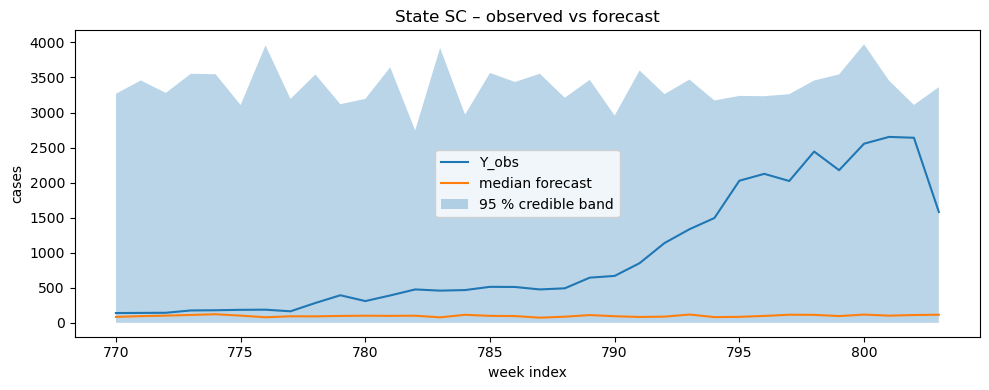

In [83]:
T = y_hist.size
plt.figure(figsize=(10, 4))
plt.plot(df_pop_state["week"].unique(), y_hist, label="Y_obs", lw=1.5)
plt.plot(df_pop_state["week"].unique(), median_fut, label="median forecast", lw=1.5)
plt.fill_between(df_pop_state["week"].unique(), lo95_fut, hi95_fut, alpha=0.3,
                 label="95 % credible band")
plt.xlabel("week index"); plt.ylabel("cases")
plt.title(f"State {inverse_state_id_map[state_id]} – observed vs forecast")
plt.legend(); plt.tight_layout(); plt.show()

In [86]:
epi_df[epi_df[target_goal]]

,date,epiweek,city_idx,Y_obs,uf,macroregional_geocode,regional_geocode,train_1,target_1,train_2,target_2,train_3,target_3,calendar_year,year_idx,week_idx,state_idx
4282429,2024-10-06,202441,3518008,1,SP,3531,35154,False,False,False,False,False,True,2024,14,770,0
4282430,2024-10-06,202441,3518701,0,SP,3520,35041,False,False,False,False,False,True,2024,14,770,0
4282431,2024-10-06,202441,3504602,3,SP,3531,35155,False,False,False,False,False,True,2024,14,770,0
4282432,2024-10-06,202441,3508702,0,SP,3528,35143,False,False,False,False,False,True,2024,14,770,0
4282433,2024-10-06,202441,3519055,2,SP,3528,35072,False,False,False,False,False,True,2024,14,770,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4471804,2025-05-25,202522,1400050,0,RR,1401,14001,False,False,False,False,False,True,2025,15,803,26
4471805,2025-05-25,202522,1400027,0,RR,1401,14001,False,False,False,False,False,True,2025,15,803,26
4471806,2025-05-25,202522,1400407,1,RR,1401,14001,False,False,False,False,False,True,2025,15,803,26
4471807,2025-05-25,202522,1400506,0,RR,1401,14002,False,False,False,False,False,True,2025,15,803,26


In [90]:
str(Week(2024, 41).startdate())

'2024-10-06'

In [92]:
start_wk = Week(2024, 41)   # EW 41-2024  ➜ Sunday  6 Oct 2024
end_wk   = Week(2025, 40)   # EW 40-2025  ➜ Sunday  5 Oct 2025

weeks = []
wk = start_wk
while True:
    weeks.append(str(wk.startdate()))   # (YYYY, EW, date)
    if wk == end_wk:
        break
    wk = wk + 1        # epiweeks overloads + 1 to mean “next EW”

['2024-10-06',
 '2024-10-13',
 '2024-10-20',
 '2024-10-27',
 '2024-11-03',
 '2024-11-10',
 '2024-11-17',
 '2024-11-24',
 '2024-12-01',
 '2024-12-08',
 '2024-12-15',
 '2024-12-22',
 '2024-12-29',
 '2025-01-05',
 '2025-01-12',
 '2025-01-19',
 '2025-01-26',
 '2025-02-02',
 '2025-02-09',
 '2025-02-16',
 '2025-02-23',
 '2025-03-02',
 '2025-03-09',
 '2025-03-16',
 '2025-03-23',
 '2025-03-30',
 '2025-04-06',
 '2025-04-13',
 '2025-04-20',
 '2025-04-27',
 '2025-05-04',
 '2025-05-11',
 '2025-05-18',
 '2025-05-25',
 '2025-06-01',
 '2025-06-08',
 '2025-06-15',
 '2025-06-22',
 '2025-06-29',
 '2025-07-06',
 '2025-07-13',
 '2025-07-20',
 '2025-07-27',
 '2025-08-03',
 '2025-08-10',
 '2025-08-17',
 '2025-08-24',
 '2025-08-31',
 '2025-09-07',
 '2025-09-14',
 '2025-09-21',
 '2025-09-28']

In [96]:
q = [0.025, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.975]
quant = torch.quantile(Y_future, torch.tensor(q), dim=0)
pi95_lo, pi90_lo, pi80_lo, pi50_lo, median, \
pi50_hi, pi80_hi, pi90_hi, pi95_hi = quant.cpu().numpy()


S, H = median.shape          
weeks_future = np.arange(H)  
results = dict({})
for s in range(S):
    records = []
    uf = inverse_state_id_map[s]          
    for h in range(H):
        records.append(
            dict(                                
                lower_50 = pi50_lo[s, h],      
                lower_80 = pi80_lo[s, h],
                lower_90 = pi90_lo[s, h],
                lower_95 = pi95_lo[s, h],
                pred = median[s, h],
                upper_50 = pi50_hi[s, h],
                upper_80 = pi80_hi[s, h],               
                upper_90 = pi90_hi[s, h],                                
                upper_95 = pi95_hi[s, h],
                date = weeks[h],
            )
        )

    df_forecast = pd.DataFrame.from_records(records)
    results[uf] = df_forecast

In [97]:
results

{'SP':     lower_50   lower_80   lower_90  lower_95    pred  upper_50      upper_80  \
 0     412.25  58.700005   9.000000     1.975  2110.0   6868.00  14556.798828   
 1     540.75  84.900002  23.000000     2.975  2397.0   6842.50  14424.496094   
 2     524.00  68.800003  19.950001     4.000  2379.5   7286.50  14829.498047   
 3     381.00  45.000000   7.000000     2.000  2212.0   7117.25  14237.198242   
 4     483.75  60.600006  15.000000     3.975  2325.5   7075.50  14128.000000   
 5     454.00  55.900002  14.000000     4.000  2039.5   6735.00  14591.499023   
 6     519.25  91.000000  16.000000     5.000  2208.5   6894.75  13475.897461   
 7     528.00  60.800003  12.000000     3.000  2108.5   6985.00  14720.198242   
 8     398.50  45.900002  12.950001     2.000  2198.0   6695.25  13292.499023   
 9     597.50  85.800003  12.000000     4.000  2391.0   7106.00  14956.400391   
 10    381.75  67.900002  13.900002     1.975  2143.0   6940.50  13677.299805   
 11    449.25  60.9000